In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
price_df = pd.read_csv("price_data.csv",
                       parse_dates=["GMT Time"],
                       na_values=['No Data Available']
                       )
price_df.columns = ["Time", "DA Price", "Intraday Price"]
# price_df.set_index("Time", inplace=True)
# price_df.rename_axis("Series", axis="columns", inplace=True)

generation_df = pd.read_csv("generation_data.csv",
                            parse_dates=["GMT Time"],
                            na_values=["No Data Available"])
generation_df.columns = ["Time",
                         "Biomass",
                         "Gas",
                         "Hard Coal",
                         "Oil",
                         "Hydro Pumped Storage",
                         "Hydro Run-of-River",
                         "Nuclear",
                         "Solar",
                         "Wind Onshore",
                         "Wind Offshore"]
# generation_df.set_index("Time", inplace=True)
# generation_df.rename_axis("Series", axis="columns", inplace=True)

demand_load_df = pd.read_csv("demand_load_data.csv",
                             parse_dates=["GMT Time"],
                             na_values=["No Data Available"])
demand_load_df.columns = ["Time", "Loss of Load Prob", "Actual Total Load", "Demand Outturn"]
# demand_load_df.set_index("Time", inplace=True)
# demand_load_df.rename_axis("Series", axis="columns", inplace=True)

balancing_df = pd.read_csv("balancing_data.csv",
                           parse_dates=["GMT Time"],
                           na_values=['No Data Available']
                           )
balancing_df.columns = ["Time",
                        "System Price",
                        "NIV Outturn",
                        "BM Bid Acceptances",
                        "BM Offer Acceptances",
                        "BSAD Volume Turn Up",
                        "BSAD Volume Turn Down",
                        "BSAD Volume Total",
                        "Intraday Volume"]
# balancing_df.set_index("Time", inplace=True)
# balancing_df.rename_axis("Series", axis="columns", inplace=True)

### Price data

In [ ]:
price_df.head()

Time  DA Price  Intraday Price
0 2018-01-01 00:00:00     46.73           47.27
1 2018-01-01 00:30:00     50.11           48.57
2 2018-01-01 01:00:00     56.60           52.32
3 2018-01-01 01:30:00     51.83           51.18
4 2018-01-01 02:00:00     46.23           46.08

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118320 entries, 0 to 118319
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Time            118320 non-null  datetime64[ns]
 1   DA Price        118256 non-null  float64       
 2   Intraday Price  117680 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.7 MB


We took a general overview of the data, what variables we have and what kind of variables these are. In this case we can see Time is a date-time variable, and DA Price and Intraday Price are Floats.

In [ ]:
price_df.describe()

Time       DA Price  Intraday Price
count                         118320  118256.000000   117680.000000
mean   2021-05-17 11:45:00.000000256      89.006159       86.896807
min              2018-01-01 00:00:00     -86.300000      -77.290000
25%              2019-09-09 05:52:30      43.700000       42.470000
50%              2021-05-17 11:45:00      64.100000       62.700000
75%              2023-01-23 17:37:30     102.400000      101.922500
max              2024-09-30 23:30:00    2500.000000     1983.660000
std                              NaN      81.321488       78.471789

We then took a look at some of the statistics of the dataset

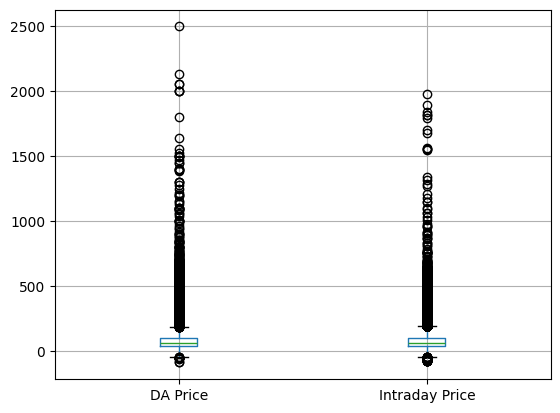

In [ ]:
price_df.boxplot()
plt.show()

In [ ]:
price_df.columns

Index(['Time', 'DA Price', 'Intraday Price'], dtype='object')

In [ ]:
fig = px.area(price_df, x="Time", y=price_df.columns,
              hover_data={"Time": "|%B %d, %Y"},
              title='DA Price & Intraday Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
# fig = px.area(price_df.set_index("Time").rename_axis("Series", axis='columns'), facet_col="Series", facet_col_wrap=1,
#               title='DA Price & Intraday Price')
# fig.layout['xaxis1'] = {'rangeslider': {'visible': True}}
# fig.show()

After taking a look at the data, we moved on to do exploratory analysis. The first thing we did was decide what to do with the missing values we found above. The first measure we took was to handle them with forward fill, making them valid while not overwriting the data (mainecita's notes, can be changed)

In [ ]:
print("Missing values:\n", price_df['DA Price'].isnull().sum())
price_df['DA Price'] = price_df['DA Price'].fillna(method='ffill')  # Forward fill method for missing values



Missing values:
 64


<ipython-input-10-ac8f3273b644>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



The next thing we did was look for stationarity. For this we did an Augmented Dickey-Fuller (ADF) test.

For this, we decided upon the following Hypothesis to test:

Null Hypothesis (𝐻0): The time series is non-stationary.
Alternative Hypothesis (𝐻1): The time series is stationary.

In [ ]:
adfuller(price_df['DA Price'])

(-8.107524272214649,
 1.2511923718248523e-12,
 71,
 118248,
 {'1%': -3.430405302770123,
  '5%': -2.861564442999535,
  '10%': -2.5667830101460924},
 1012468.3553004458)

The results show that the ADF statistic is much smaller than all critical values, so we reject the null hypothesis. At the same time, they show a small p-value, meaning that we reject the null hypothesis. With these results we thus assume stationarity. This means we do not need to apply transformations to the data before modeling it.

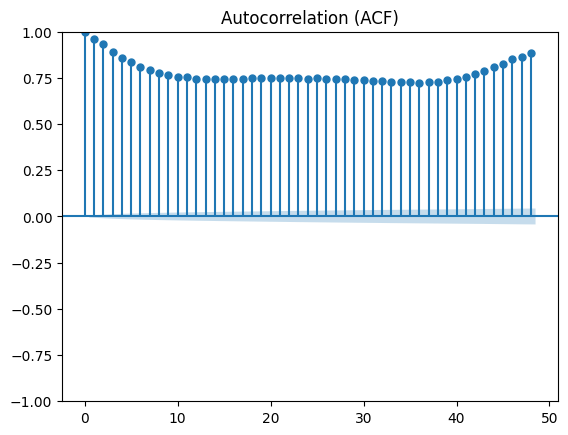

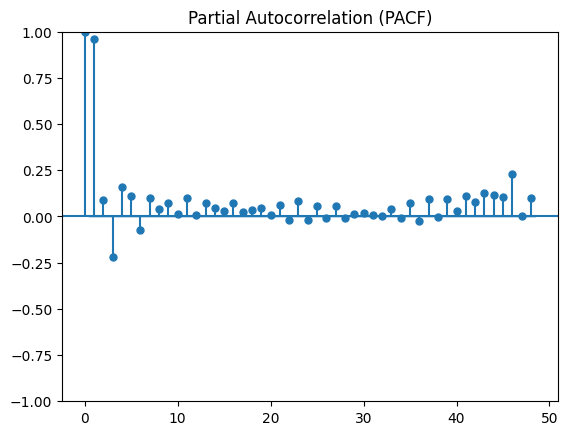

In [ ]:
#ACF
plot_acf(price_df['DA Price'], lags=48) #Lags are the cycles, set to 48 since the data is set to 48-intervals
plt.title("Autocorrelation (ACF)")
plt.show()

#PACF
plot_pacf(price_df['DA Price'], lags=48)
plt.title("Partial Autocorrelation (PACF)")
plt.show()

The ACF plot shows a slow decay over time, with significant correlations for many lags. This can indicate non-stationarity, as the autocorrelations do not drop off quickly. This can also suggest the presence of trends or seasonality in the data. Differencing can remove this persistence in correlations.

The PACF plot shows a sharp drop-off after lag 1, with no significant spikes beyond that. This can tell us that a lag of 1 might be sufficient for the autoregressive (AR) part of the model.


In [ ]:
#Deciding the split of the training/Test datasets
len(price_df['DA Price'])

split_index = (len(price_df['DA Price']) * 0.8)

split_index

94656.0

In [ ]:
# Training data: 80% of the data
train_data = price_df['DA Price'][:94656]
train_data = train_data[-10000:] #This is what Michelle told us to do in the call
# I selected a smaller subset of data to see if it runs - Mainecita


# Test data: Remaining 20% of the data
test_data = price_df['DA Price'][94656:]

In [ ]:
# Fit ARIMA Model
# Parameters determined from PACF and ACF (p=1, d=1, q=1)
# I get a warning when running it, Even though the data passed the ADF test for stationarity,
# small numerical issues or borderline stationarity can trigger this warning.
p = 1
d = 1
q = 1
arima_model = ARIMA(train_data, order=(p, d, q))
arima_fit = arima_model.fit()

In [ ]:
# Forecast using ARIMA
arima_forecast = arima_fit.forecast(steps=48)  # Forecast 48 half-hour intervals
arima_forecast

94656    76.065872
94657    74.026263
94658    75.428887
94659    74.464313
94660    75.127644
94661    74.671476
94662    74.985179
94663    74.769448
94664    74.917805
94665    74.815781
94666    74.885942
94667    74.837693
94668    74.870873
94669    74.848055
94670    74.863747
94671    74.852956
94672    74.860377
94673    74.855274
94674    74.858783
94675    74.856370
94676    74.858029
94677    74.856888
94678    74.857673
94679    74.857133
94680    74.857504
94681    74.857249
94682    74.857425
94683    74.857304
94684    74.857387
94685    74.857330
94686    74.857369
94687    74.857342
94688    74.857361
94689    74.857348
94690    74.857357
94691    74.857351
94692    74.857355
94693    74.857352
94694    74.857354
94695    74.857353
94696    74.857353
94697    74.857353
94698    74.857353
94699    74.857353
94700    74.857353
94701    74.857353
94702    74.857353
94703    74.857353
Name: predicted_mean, dtype: float64

In [ ]:
# Fit SARIMA Model
# Seasonal parameters (P=1, D=0, Q=0, m=48) based on daily seasonality assumption
P, D, Q, m = 1, 0, 0, 48
sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))


In [ ]:
sarima_fit = sarima_model.fit(disp=False)

In [ ]:
# Forecast using SARIMA
sarima_forecast = sarima_fit.forecast(steps=48)

94656    69.878966
94657    73.757087
94658    74.062517
94659    72.247875
94660    71.546264
94661    71.859540
94662    73.225247
94663    70.787022
94664    76.438348
94665    77.424486
94666    81.309466
94667    85.067433
94668    81.691864
94669    90.724905
94670    84.686645
94671    83.959667
94672    82.752679
94673    77.435425
94674    77.435956
94675    73.279136
94676    75.019276
94677    77.290700
94678    76.372498
94679    72.795935
94680    73.037628
94681    69.219444
94682    71.636016
94683    71.636007
94684    71.587682
94685    71.587678
94686    69.291951
94687    72.795957
94688    74.632542
94689    77.290754
94690    78.450702
94691    82.607181
94692    89.518535
94693    87.295302
94694    87.488627
94695    84.298771
94696    86.908653
94697    84.685420
94698    86.135355
94699    77.435748
94700    77.435748
94701    81.302240
94702    82.268863
94703    78.934014
Name: predicted_mean, dtype: float64

In [ ]:
# Evaluate Models
def evaluate_forecast(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    print(f"{model_name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 30)

In [ ]:
test_data_48 = test_data.iloc[:48]

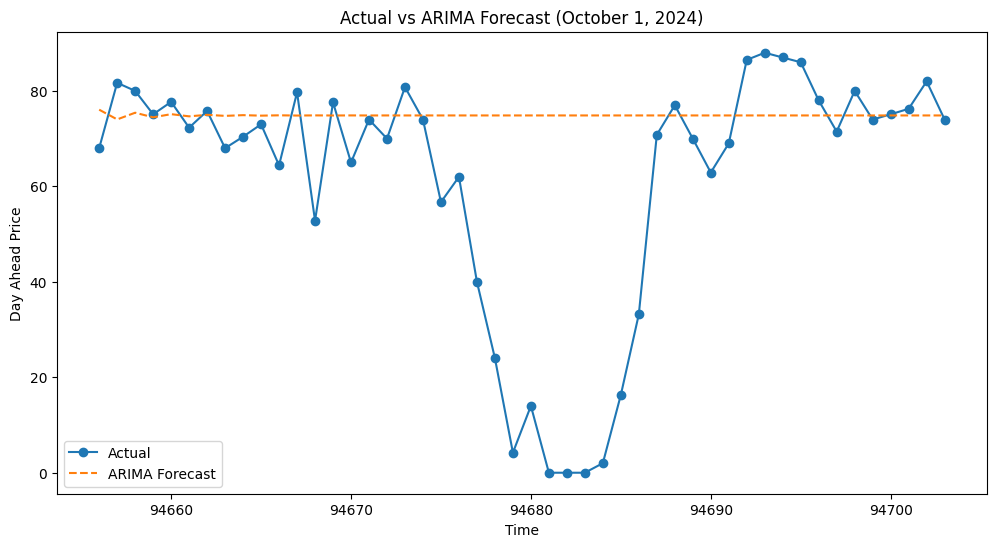

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_48.index, test_data_48.values, label="Actual", marker='o')
plt.plot(test_data_48.index, arima_forecast, label="ARIMA Forecast", linestyle='--')
plt.title("Actual vs ARIMA Forecast (October 1, 2024)")
plt.xlabel("Time")
plt.ylabel("Day Ahead Price")
plt.legend()
plt.show()

((Here is where I got lost))

In [ ]:
# Evaluate ARIMA
evaluate_forecast(test_data.values, arima_forecast, "ARIMA")

# Evaluate SARIMA
evaluate_forecast(test_data.values, sarima_forecast, "SARIMA")

ValueError: Found input variables with inconsistent numbers of samples: [23664, 48]

### Generation Data

In [ ]:
generation_df.head()

Series               Biomass     Gas  Hard Coal  Oil  Hydro Pumped Storage  \
Time                                                                         
2018-01-01 00:00:00    710.0  5190.0     1143.0  0.0                   0.0   
2018-01-01 00:30:00    749.0  5574.0     1308.0  0.0                   0.0   
2018-01-01 01:00:00    756.0  5753.0     1461.0  0.0                 206.0   
2018-01-01 01:30:00    757.0  5616.0     1587.0  0.0                   0.0   
2018-01-01 02:00:00    747.0  5192.0     1591.0  0.0                   0.0   

Series               Hydro Run-of-River  Nuclear  Solar  Wind Onshore  \
Time                                                                    
2018-01-01 00:00:00               352.0   7263.0    0.0       4950.30   
2018-01-01 00:30:00               351.0   7268.0    0.0       5004.55   
2018-01-01 01:00:00               355.0   7260.0    0.0       4878.41   
2018-01-01 01:30:00               349.0   7258.0    0.0       4969.68   
2018-01-01 02:00:00               340.0   7264.0    0.0       4720.91   

Series               Wind Offshore  
Time                                
2018-01-01 00:00:00        3777.01  
2018-01-01 00:30:00        3824.89  
2018-01-01 01:00:00        3831.16  
2018-01-01 01:30:00        3811.42  
2018-01-01 02:00:00        3819.08

In [ ]:
generation_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Biomass               116125 non-null  float64
 1   Gas                   116125 non-null  float64
 2   Hard Coal             116125 non-null  float64
 3   Oil                   116125 non-null  float64
 4   Hydro Pumped Storage  116125 non-null  float64
 5   Hydro Run-of-River    116125 non-null  float64
 6   Nuclear               116125 non-null  float64
 7   Solar                 116125 non-null  float64
 8   Wind Onshore          116125 non-null  float64
 9   Wind Offshore         116125 non-null  float64
dtypes: float64(10)
memory usage: 9.9 MB


In [ ]:
generation_df.describe()

Series        Biomass            Gas      Hard Coal            Oil  \
count   116125.000000  116125.000000  116125.000000  116125.000000   
mean      1845.667238   11122.087681     648.376741       0.001541   
std        755.838742    5805.512071    1207.322869       0.314430   
min          0.000000       0.000000       0.000000       0.000000   
25%       1369.000000    6379.000000       0.000000       0.000000   
50%       1920.000000   10947.000000     230.000000       0.000000   
75%       2352.000000   15550.000000     874.000000       0.000000   
max       3334.000000   27150.000000   11343.000000     103.000000   

Series  Hydro Pumped Storage  Hydro Run-of-River        Nuclear  \
count          116125.000000       116125.000000  116125.000000   
mean              213.997206          381.599410    5196.583677   
std               359.671016          246.053759    1440.245301   
min                 0.000000            0.000000       0.000000   
25%                 0.000000          175.000000    4544.000000   
50%                 0.000000          354.000000    5196.000000   
75%               300.000000          550.000000    6171.000000   
max              2473.000000         1424.000000    8330.000000   

Series          Solar   Wind Onshore  Wind Offshore  
count   116125.000000  116125.000000  116125.000000  
mean      1323.485727    3000.135630    2660.478686  
std       2030.524355    2015.163896    2277.310723  
min          0.000000       0.000000     -38.510000  
25%          0.000000    1328.760000     781.960000  
50%         19.000000    2526.260000    2032.240000  
75%       2160.000000    4338.850000    4086.600000  
max      10322.000000   11207.950000   11631.920000

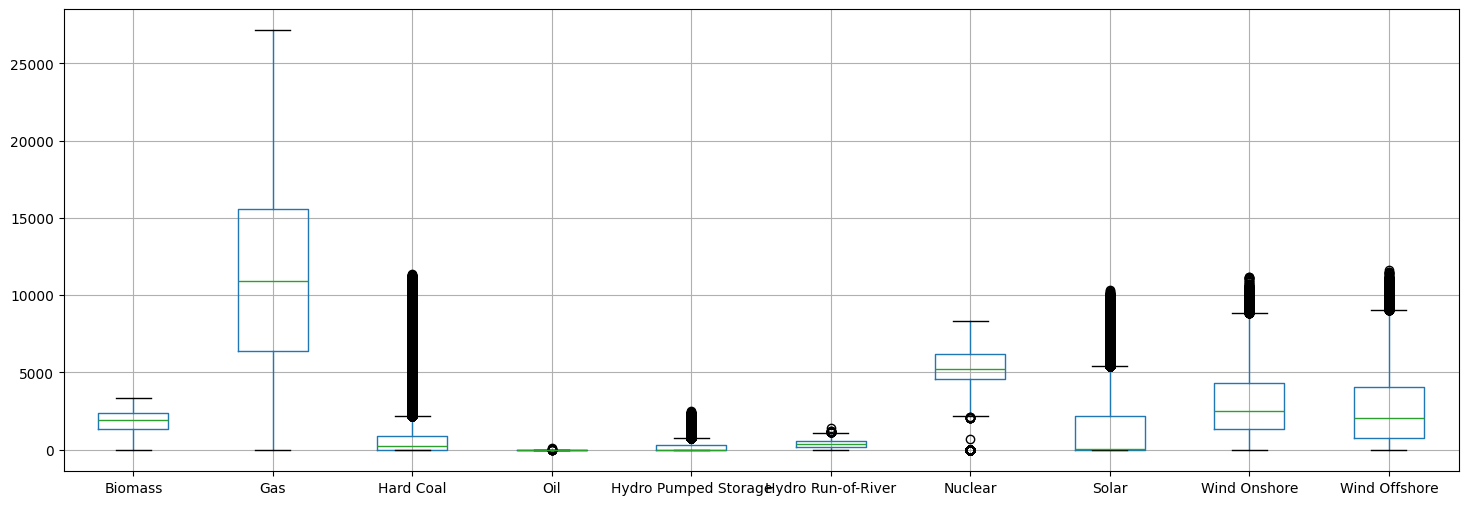

In [ ]:
generation_df.boxplot(figsize=(18,6))
plt.show()

In [ ]:
fig = px.area(generation_df.set_index("Time").rename_axis("Series", axis='columns'), facet_col="Series", facet_col_wrap=3,
              title='Actual Aggregated Generation By Type')
fig.layout['xaxis'] = {'rangeslider': {'visible': True}}
fig.show()

### Demand Load Data

In [ ]:
demand_load_df.head()

Series               Loss of Load Prob  Actual Total Load  Demand Outturn
Time                                                                     
2018-01-01 00:00:00                0.0            30303.0         26413.0
2018-01-01 00:30:00                0.0            31096.0         27130.0
2018-01-01 01:00:00                0.0            30599.0         27378.0
2018-01-01 01:30:00                0.0            29402.0         26746.0
2018-01-01 02:00:00                0.0            28096.0         26169.0

In [ ]:
demand_load_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Loss of Load Prob  117764 non-null  float64
 1   Actual Total Load  116229 non-null  float64
 2   Demand Outturn     117749 non-null  float64
dtypes: float64(3)
memory usage: 3.6 MB


In [ ]:
demand_load_df.describe()

Series  Loss of Load Prob  Actual Total Load  Demand Outturn
count       117764.000000      116229.000000   117749.000000
mean             0.000133       32493.608032    29371.722180
std              0.005395        7950.067231     6115.703448
min              0.000000         203.000000    16648.000000
25%              0.000000       26629.000000    24673.000000
50%              0.000000       32744.000000    28550.000000
75%              0.000000       38246.000000    33086.000000
max              0.700000       71273.000000    50499.000000

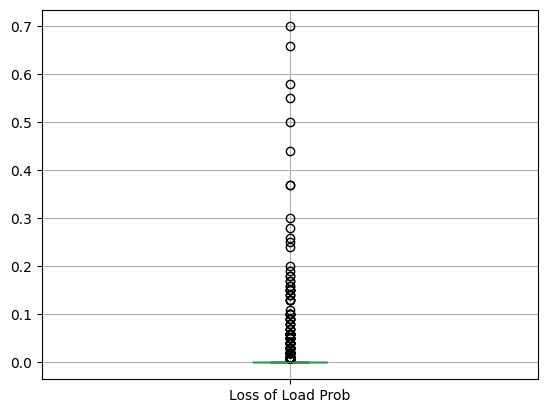

In [ ]:
demand_load_df.boxplot(column=["Loss of Load Prob"])
plt.show()

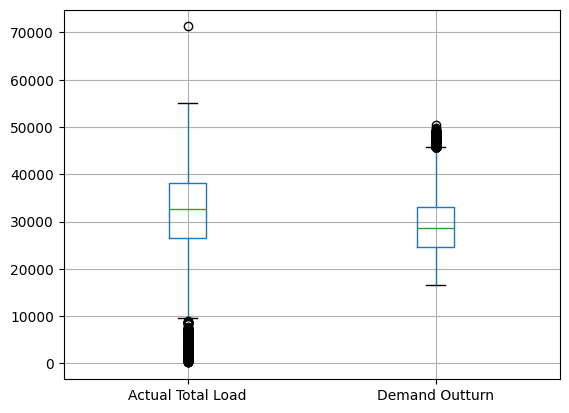

In [ ]:
demand_load_df.boxplot(column=["Actual Total Load", "Demand Outturn"])
plt.show()

In [ ]:
fig = px.area(demand_load_df.set_index("Time").rename_axis("Series", axis='columns'), facet_col="Series", facet_col_wrap=1,
              title='Actual Aggregated Generation By Type')
fig.layout['xaxis'] = {'rangeslider': {'visible': True}}
fig.update_yaxes(matches=None, row=3)
fig.show()

### Balancing Data



In [ ]:
balancing_df.head()

Time  System Price  NIV Outturn  BM Bid Acceptances  \
0 2018-01-01 00:00:00         55.94       -77.05            -1833.86   
1 2018-01-01 00:30:00         55.94      -334.76            -1443.78   
2 2018-01-01 01:00:00         62.94      -219.78            -1580.12   
3 2018-01-01 01:30:00         31.00       286.63            -1699.05   
4 2018-01-01 02:00:00         60.81      -141.41            -1413.27   

   BM Offer Acceptances  BSAD Volume Turn Up  BSAD Volume Turn Down  \
0               1910.98               1104.0                 -900.0   
1               1778.09               1104.0                 -900.0   
2               1799.90               1104.0                 -900.0   
3               1413.04               1104.0                 -900.0   
4               1554.31               1104.0                -1050.0   

   BSAD Volume Total  Intraday Volume  
0              204.0           781.35  
1              204.0           655.40  
2              204.0           821.50  
3              204.0           815.20  
4               54.0           709.05

In [ ]:
balancing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118320 entries, 0 to 118319
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Time                   118320 non-null  datetime64[ns]
 1   System Price           118275 non-null  float64       
 2   NIV Outturn            118320 non-null  float64       
 3   BM Bid Acceptances     117768 non-null  float64       
 4   BM Offer Acceptances   116849 non-null  float64       
 5   BSAD Volume Turn Up    62465 non-null   float64       
 6   BSAD Volume Turn Down  47406 non-null   float64       
 7   BSAD Volume Total      81271 non-null   float64       
 8   Intraday Volume        117680 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 8.1 MB


In [ ]:
balancing_df.describe()

Time   System Price    NIV Outturn  \
count                         118320  118275.000000  118320.000000   
mean   2021-05-17 11:45:00.000000256      87.616001      15.735880   
min              2018-01-01 00:00:00    -185.330000   -4954.350000   
25%              2019-09-09 05:52:30      38.800000    -357.072500   
50%              2021-05-17 11:45:00      60.930000       0.000000   
75%              2023-01-23 17:37:30     108.000000     389.200000   
max              2024-09-30 23:30:00    4037.800000    4566.920000   
std                              NaN     103.063221     654.902376   

       BM Bid Acceptances  BM Offer Acceptances  BSAD Volume Turn Up  \
count       117768.000000         116849.000000         62465.000000   
mean         -1573.177583           1568.341763           562.006569   
min         -11283.670000              0.000000             0.000000   
25%          -2193.100000            696.650000           173.230000   
50%          -1281.320000           1302.660000           400.000000   
75%           -693.522500           2213.630000           780.180000   
max              0.000000          10270.560000          6200.000000   
std           1157.761285           1136.994053           566.468735   

       BSAD Volume Turn Down  BSAD Volume Total  Intraday Volume  
count           47406.000000       81271.000000    117680.000000  
mean             -878.923830         -80.724031      1241.929149  
min             -6226.000000       -6226.000000         0.000000  
25%             -1263.750000        -512.000000       771.537500  
50%              -654.000000          18.000000      1160.800000  
75%              -270.000000         360.000000      1612.162500  
max                -0.010000        6200.000000      4991.000000  
std               823.761958         922.975701       638.596989

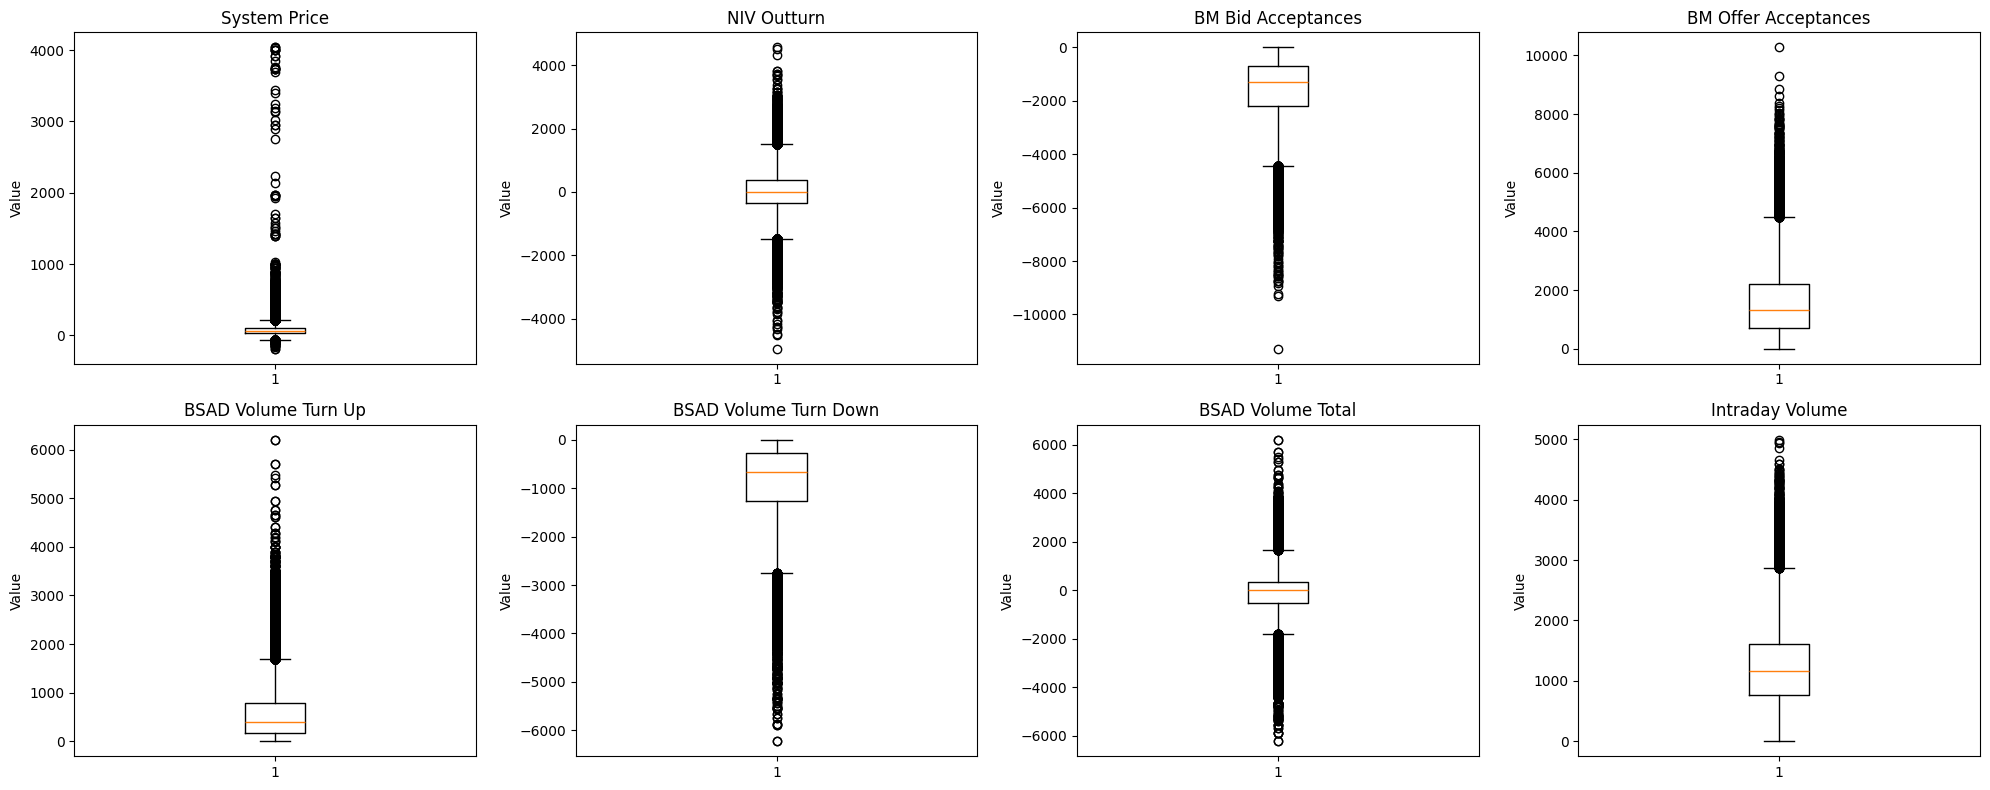

In [ ]:
num_cols = len(balancing_df.iloc[:,1:].columns)  # Number of columns to plot
nrows = (num_cols + 3) // 4  # Number of rows needed for four columns

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows * 4))

# Flatten axes array to make it easier to iterate
axes = axes.flatten()

# Plot each column in its own subplot
for i, column in enumerate(balancing_df.iloc[:,1:].columns):
    axes[i].boxplot(balancing_df.iloc[:,1:][column].dropna())
    axes[i].set_title(column)
    axes[i].set_ylabel("Value")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [1]:
fig = px.area(balancing_df.set_index("Time").rename_axis("Series", axis='columns'), facet_col="Series", facet_col_wrap=1,
              title='Actual Aggregated Generation By Type')
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness=0.05, row=1)
fig.update_yaxes(matches=None)
fig.update_layout(height=1200)
fig.show()

NameError: name 'px' is not defined

Bad pipe message: %s [b'"Microsoft Edge";v="131", "Chromium";v="131", "Not_A Bran']
Bad pipe message: %s [b';v="24"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua-platform: "Windows"\r\nDNT: 1\r\nUpgrade-Insecure-Requests: 1\r']
Bad pipe message: %s [b'ser-Agent', b'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537']
Bad pipe message: %s [b'6 (KHTML, like Gecko) Chrome/131.0.0.0 Safari', b'37.36 Edg/131.0.0.0\r\nAccept: text/html,applica', b'on/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.', b'\nSec-Fetch-Site: none\r\nSec-Fetch-Mode: navigate\r\nSec-F', b'ch-User: ?1\r\nSec-Fetch-Dest: document\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nAccept-Language: en']
Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Microsoft Edge";v="131", "Chromium";v="131", "Not_A Brand";v="24"\r\nsec-ch-ua-mobile: ?0\r']
Bad pipe message: %s [b'ec-ch-ua-', b'atform: "Windows"\r\nDNT: 1\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Moz